In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import json
from scipy.optimize import minimize, NonlinearConstraint
from scipy.optimize import basinhopping

In [3]:
# Define a color palette
palette = ["#2F4858", "#A02829", "#33658A", "#E6823B", "#D34E5B", "#4A8C82", "#C0A184", "#86BBD8", "#6B92A4", "#CFB54E", "#97A169", "#C9A0DC",]
fs=16

# Import fit parameters (before cycle)

In [5]:
GHz,MHz,kHz = 2*np.pi,2*np.pi*1e-3,2*np.pi*1e-6
ns,us,ms = 1,1e3,1e6

In [6]:
# Experimental data

#f01 = 3.603430*GHz
f01 = 3.60374955*GHz

f02_00 = (3.485865*GHz - 0.32*MHz)*2
f02_05 = (3.485865*GHz + 0.32*MHz)*2

f03_00 = (3.3548*GHz + 3.2*MHz)*3
f03_05 = (3.3548*GHz - 3.2*MHz)*3

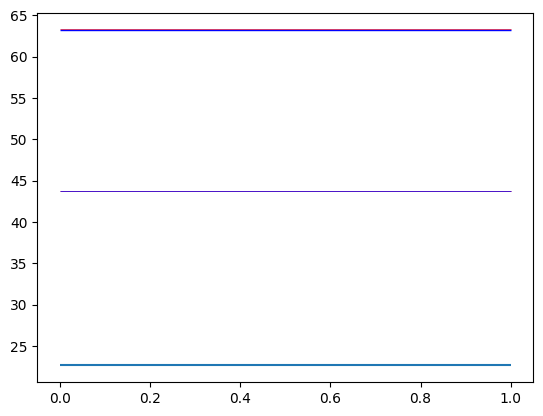

In [7]:
plt.hlines(f01,0,1)
plt.hlines(f02_00,0,1,color='red',linewidth=0.5)
plt.hlines(f02_05,0,1,color='blue',linewidth=0.5)
plt.hlines(f03_00,0,1,color='red',linewidth=0.5)
plt.hlines(f03_05,0,1,color='blue',linewidth=1)

#plt.ylim(43.5,44)

In [8]:
f12_00 = f02_00-f01
f12_05 = f02_05-f01

f23_00 = f03_00-f02_00
f23_05 = f03_05-f02_05

In [9]:
f12_00/GHz

3.36734045

In [10]:
f23_00/GHz

3.1029100000000014

In [11]:
omega_r_g_spect = 7.0548 * GHz
chi2_spect = 2.5 * MHz
omega_r_e_spect = omega_r_g_spect - chi2_spect
experimental_freq={'f01':f01,'f12_00':f12_00,'f12_05':f12_05,'f23_00':f23_00,'f23_05':f23_05,'omega_r_g':omega_r_g_spect,'chi2':chi2_spect
}

In [12]:
json_data={'fq_meas_00': np.array([f01,f02_00,f03_00])/GHz, 
           'fq_meas_05': np.array([f01,f02_05,f03_05])/GHz,
           'fr_meas': np.array([omega_r_g_spect,omega_r_e_spect])/GHz, 
           'EC': 0.200, 
           'EJ':8.7,
           'fr_b': omega_r_g_spect/GHz, 
           'g': 0.10}

# Fit Transmon-Resonator Parameters

In [ ]:
def get_label(eigvecs,Initial_basis):
    ''' 
    Computes max overlap between two set of states
    '''
    labels=[]
    for element in Initial_basis:
        prod = np.abs(np.dot(np.conj(eigvecs).transpose(2,1,0), element))**2
        labels.append(np.argmax(prod))
    return labels

class HarmonicTransmon:
    
    def __init__(self, EJ, EC, ng,truncated_dim, ncut=100):
        """
        Initialize the HarmonicTransmon class.

        Parameters:
        EJ : list of floats
            Josephson energies for each harmonic term.
        EC : float
            Charging energy.
        ng : float
            Offset charge.
        ncut : int
            Charge basis cutoff.
        truncated_dim : int, optional
            Dimension after truncation.
        """
        self.EJ = EJ
        self.EC = EC
        self.ng = ng
        self.ncut = ncut
        self.n_harmonics = len(EJ)
        self.truncated_dim = truncated_dim
        self.truncated_operators()#Generated truncated and diagonalized operators
    def hilbertdim(self):
        """
        Returns the dimension of the Hilbert space.
        """
        return 2 * self.ncut + 1

    def cos_m_phi_operator(self, m):
        """
        Returns the operator cos(m*phi) in the charge basis.

        Parameters:
        m : int
            Harmonic index.
        """
        dimension = self.hilbertdim()
        cos_op = np.zeros((dimension, dimension))
        for n in range(dimension - m):
            cos_op[n, n + m] = 0.5
            cos_op[n + m, n] = 0.5
        return cos_op

    def hamiltonian(self):
        """
        Returns the Hamiltonian in the charge basis.
        """
        dimension = self.hilbertdim()
        self.n_operator=np.diag(np.linspace(-self.ncut, self.ncut, dimension))
        hamiltonian_mat = 4 * self.EC * (self.n_operator - np.eye(self.hilbertdim())*self.ng) ** 2
        
        for m in range(1, self.n_harmonics + 1):
            hamiltonian_mat += -self.EJ[m-1] * self.cos_m_phi_operator(m)
        return hamiltonian_mat
    
    def truncated_operators(self):
        """
        Returns the truncated Hamiltonian in the charge basis.
        """
        eigvals,eigvecs=np.linalg.eigh(self.hamiltonian())
        self.Hdiagonal=self.basis_change(eigvecs,self.hamiltonian())[0:self.truncated_dim,0:self.truncated_dim]
        self.n_diagonal=self.basis_change(eigvecs,self.n_operator)[0:self.truncated_dim,0:self.truncated_dim]
        self.n_diagonal=1/2*(self.n_diagonal+np.conj(np.transpose(self.n_diagonal)))

    def basis_change(self,newbasis,operator):
        """
        Returns the operator in the new basis.
        """
        return np.dot(np.conj(np.transpose(newbasis)),np.dot(operator,newbasis))

class CoupledHarmonicTransmonResonator:
    def __init__(self, EJ, EC, ng, truncated_dim, n_harmonics, fr_b, g, r_levels):
        self.hmon = HarmonicTransmon(EJ, EC, ng, truncated_dim)
        self.fr_b = fr_b
        self.g = g
        self.r_levels = r_levels

    def hamiltonian(self):
        dim_hmon = self.hmon.truncated_dim
        dim_res = self.r_levels

        H_t = np.kron(self.hmon.Hdiagonal, np.eye(dim_res))
        H_r = np.diag([r * self.fr_b for r in range(dim_res)])
        H_r = np.kron(np.eye(dim_hmon), H_r)
        a = np.diag(np.sqrt(np.arange(1, dim_res)), 1)
        a_dagger = np.diag(np.sqrt(np.arange(1, dim_res)), -1)
        V = self.g * np.kron(self.hmon.n_diagonal-np.eye(dim_hmon)*self.hmon.ng, (a + a_dagger))
        return H_t + H_r + V

    def diagonalize(self):
        H = self.hamiltonian()
        evals, evecs = np.linalg.eigh(H)
        self.evals = evals - evals[0]  # Shift energies to have the ground state at 0
        self.evecs = evecs

    def sort_eigenenergies(self, q_photons=15, r_photons=1,max_photons=-1):
        self.diagonalize()
        bare_state_0_Photon = [np.kron(np.eye(self.hmon.truncated_dim)[:, t], np.eye(self.r_levels)[:, 0]).reshape(-1,1) for t in range(q_photons+1)]
        bare_state_1_Photon = [np.kron(np.eye(self.hmon.truncated_dim)[:, t], np.eye(r_levels)[:, 1]).reshape(-1,1) for t in range(q_photons+1)]
        indices_0_Photon=get_label(self.evecs.reshape(self.hmon.truncated_dim*self.r_levels,self.hmon.truncated_dim*self.r_levels,1),bare_state_0_Photon)
        indices_1_Photon=get_label(self.evecs.reshape(self.hmon.truncated_dim*self.r_levels,self.hmon.truncated_dim*self.r_levels,1),bare_state_1_Photon)
        self.dressed_qubit=self.evals[indices_0_Photon][1:]-np.min(self.evals[indices_0_Photon])
        self.dressed_resonator=self.evals[indices_1_Photon]-self.evals[indices_0_Photon]


def Plot_fit_Predictions(result,truncated_dim=21,r_levels=10,ng=0):
    EJ=result.x[:nb_harmonics]
    EC=result.x[nb_harmonics]
    g=result.x[nb_harmonics+1]
    fr=result.x[nb_harmonics+2]

    ng=0
    coupled_system_00 = CoupledHarmonicTransmonResonator(
        EJ=EJ, 
        EC=EC, 
        ng=ng, 
        truncated_dim=truncated_dim, 
        n_harmonics=nb_harmonics, 
        fr_b=fr, 
        g=g, 
        r_levels=r_levels
    )

    ng=0.5
    coupled_system_05 = CoupledHarmonicTransmonResonator(
        EJ=EJ, 
        EC=EC, 
        ng=ng, 
        truncated_dim=truncated_dim, 
        n_harmonics=nb_harmonics, 
        fr_b=fr, 
        g=g, 
        r_levels=r_levels
    )

    coupled_system_00.sort_eigenenergies()
    coupled_system_05.sort_eigenenergies()
    dressed_qubit_00=coupled_system_00.dressed_qubit
    dressed_qubit_05=coupled_system_05.dressed_qubit
    print(dressed_qubit_00[0:3])
    print(dressed_qubit_05[0:3])

    dressed_resonator=coupled_system_00.dressed_resonator
    fq_Errors_00=fq_meas_00_all-dressed_qubit_00[0:len(fq_meas_00_all)]
    fq_Errors_05=fq_meas_05_all-dressed_qubit_05[0:len(fq_meas_05_all)]
    fr_Errors=fr_meas-dressed_resonator[0:len(fr_meas)]

    # Create a figure with three subplots
    fig, ax1 = plt.subplots(3, 1, figsize=(8, 8))

    # Plot for "Fit Pulled Resonator Frequency"
    ax1[0].set_title("Fit Pulled Resonator Frequency", fontsize=fs)
    xvals = np.arange(0, len(fr_Errors))
    ax1[0].plot(xvals, np.abs(fr_Errors) * 10**6, 'o-',color=palette[1])
    ax1[0].set_xticks(xvals)
    ax1[0].set_xticklabels(xvals, fontsize=fs - 2)
    ax1[0].tick_params(axis='y', labelsize=fs - 2)
    ax1[0].set_ylabel(r'Error on $\omega_r^{i_t}$ [kHz]', fontsize=fs)
    ax1[0].set_xlabel(r"$i_t$", fontsize=fs)

    # Plot for "Fit Pulled Qubit Frequency ng=0"
    ax1[1].set_title("Fit Pulled Qubit Frequency, ng=0", fontsize=fs)
    xvals = np.arange(0, len(fq_Errors_00))
    ax1[1].plot(xvals, np.abs(fq_Errors_00) * 10**3, 'o-',color=palette[1])
    ax1[1].set_xticks(xvals)
    ax1[1].set_xticklabels(xvals, fontsize=fs - 2)
    ax1[1].tick_params(axis='y', labelsize=fs - 2)
    ax1[1].set_ylabel(r'Error on $\omega_{0,i_t,i_t+1}$ [MHz]', fontsize=fs)
    ax1[1].set_xlabel(r"$i_t$", fontsize=fs)
    
    # Plot for "Fit Pulled Qubit Frequency ng=0"
    ax1[2].set_title("Fit Pulled Qubit Frequency, ng=0.5", fontsize=fs)
    xvals = np.arange(0, len(fq_Errors_05))
    ax1[2].plot(xvals, np.abs(fq_Errors_05) * 10**3, 'o-',color=palette[1])
    ax1[2].set_xticks(xvals)
    ax1[2].set_xticklabels(xvals, fontsize=fs - 2)
    ax1[2].tick_params(axis='y', labelsize=fs - 2)
    ax1[1].set_ylabel(r'Error on $\omega_{0,i_t,i_t+1}$ [MHz]', fontsize=fs)
    ax1[2].set_xlabel(r"$i_t$", fontsize=fs)
    print(np.abs(fq_Errors_00) * 10**3, ' MHz')
    print(np.abs(fq_Errors_05) * 10**3, ' MHz')
    print(np.abs(fr_Errors) * 10**6 , ' kHz')
    # Adjust layout for better spacing
    plt.tight_layout()

def Loss_function(params):
    ''' 
    Loss function we try to minimize in order to fit transmon parameters
    '''
    Loss=0
    EJ=params[:nb_harmonics]
    EC=params[nb_harmonics]
    g=params[nb_harmonics+1]
    fr=params[nb_harmonics+2]

    ng=0
    coupled_system_00 = CoupledHarmonicTransmonResonator(
        EJ=EJ, 
        EC=EC, 
        ng=ng, 
        truncated_dim=truncated_dim, 
        n_harmonics=nb_harmonics, 
        fr_b=fr, 
        g=g, 
        r_levels=r_levels
    )

    ng=0.5
    coupled_system_05 = CoupledHarmonicTransmonResonator(
        EJ=EJ, 
        EC=EC, 
        ng=ng, 
        truncated_dim=truncated_dim, 
        n_harmonics=nb_harmonics, 
        fr_b=fr, 
        g=g, 
        r_levels=r_levels
    )
    
    coupled_system_00.sort_eigenenergies()
    coupled_system_05.sort_eigenenergies()
    dressed_qubit_00=coupled_system_00.dressed_qubit
    dressed_qubit_05=coupled_system_05.dressed_qubit
    dressed_resonator=coupled_system_00.dressed_resonator
    for i in range(len(fq_meas_00)):
        Loss+=np.abs(dressed_qubit_00[i]-fq_meas_00[i])*wq_00_weights[i]
    for i in range(len(fq_meas_05)):
        Loss+=np.abs(dressed_qubit_05[i]-fq_meas_05[i])*wq_05_weights[i]
    for i in range(len(fr_meas)):
        Loss+=np.abs(dressed_resonator[i]-fr_meas[i])*wr_weights[i]
    return Loss

# 3 harmonics :

In [124]:
nb_freq_fit=3

# Initial Guess

#EJGuess = [json_data['EJ'],-0.1*json_data['EJ'],0.01*json_data['EJ']]
EJGuess = [8.717,-0.067,0.0035]

nb_harmonics = len(EJGuess)
# ECGuess = json_data['EC']
# gGuess = json_data['g']
# fr_bGuess = json_data['fr_b']
ECGuess = 0.217
gGuess = 0.186
fr_bGuess = 7.0476

In [125]:
x0=EJGuess+[ECGuess,gGuess,fr_bGuess]
truncated_dim=21 #Dimension after truncation
r_levels=10 #Resonator states we keep

# Data we fit
fr_meas = json_data['fr_meas']
fq_meas_00 = json_data['fq_meas_00'][:nb_freq_fit]
fq_meas_05 = json_data['fq_meas_05'][:nb_freq_fit]

fq_meas_00_all = json_data['fq_meas_00']
fq_meas_05_all = json_data['fq_meas_05']

# Weights for different transitions
wq_00_weights = np.zeros_like(fq_meas_00)
for i in range(len(wq_00_weights)):
    wq_00_weights[i] = 1/(i+1)
wq_05_weights = np.zeros_like(fq_meas_05)
for i in range(len(wq_05_weights)):
    wq_05_weights[i] = 1/(i+1)
wr_weights = np.zeros_like(fr_meas)
for i in range(len(fr_meas)):
    wr_weights[i] = 1

# Bounds for EJ
EJ_bound = [
    (0, EJGuess[0]*10), 
    (-1, 0),
    (0, 1), (-1, 0),
    (0, 1), (-1, 0),
    (0, 1), (-1, 0),
    (0, 1), (-1, 0)
]

# Bounds for other parameters
bounds = EJ_bound[:nb_harmonics]+[
    (ECGuess*0.1, ECGuess*10),
    (gGuess*0.1, gGuess*10),
    (fr_bGuess*0.9, fr_bGuess*1.1)
]


# Constraints on EJ
def abs_greater_constraint(x, i):
    return abs(x[i]) - abs(x[i+1])
# Create constraints for given n
def create_constraints(n):
    constraints = []
    for i in range(n - 1):
        constraints.append(NonlinearConstraint(lambda x, i=i: abs_greater_constraint(x, i), 0, np.inf))
    return constraints
# Create constraints
constraints = create_constraints(len(EJGuess))

# Options for the optimizer
options = {
    'ftol': 1e-12,  # Function tolerance
    'maxfun': 100000,  # Maximum number of function evaluations
    #'maxiter': 100000,
    #'eps': 1e-9
}

/var/folders/6v/y8v8x2ds6b55nwr0_7jg1q1r0000gq/T/ipykernel_25229/2124237325.py:4: OptimizeWarning: Unknown solver options: maxfun
  result = minimize(Loss_function, x0,method='SLSQP', bounds=bounds, options=options,constraints=constraints)


[ 3.60376373  6.97109    10.07400011]
[ 3.60371475  6.97236021 10.05479977]
[1.41762420e-02 1.52233781e-09 1.09329680e-04]
[0.03479789 0.00979474 0.0002295 ]
Loss:  5.495476730728773e-05 , Iterations:  48
Parameter:  EJ1  Bounds:  (0, 87.17)  Optimal value:  8.717862654789487
Parameter:  EJ2  Bounds:  (-1, 0)  Optimal value:  -0.06694206359451146
Parameter:  EJ3  Bounds:  (0, 1)  Optimal value:  0.0034684306473925027
Parameter:  EC  Bounds:  (0.0217, 2.17)  Optimal value:  0.2166222390426093
Parameter:  g  Bounds:  (0.018600000000000002, 1.8599999999999999)  Optimal value:  0.18647882941197633
Parameter:  fr_b  Bounds:  (6.34284, 7.75236)  Optimal value:  7.047670130602469


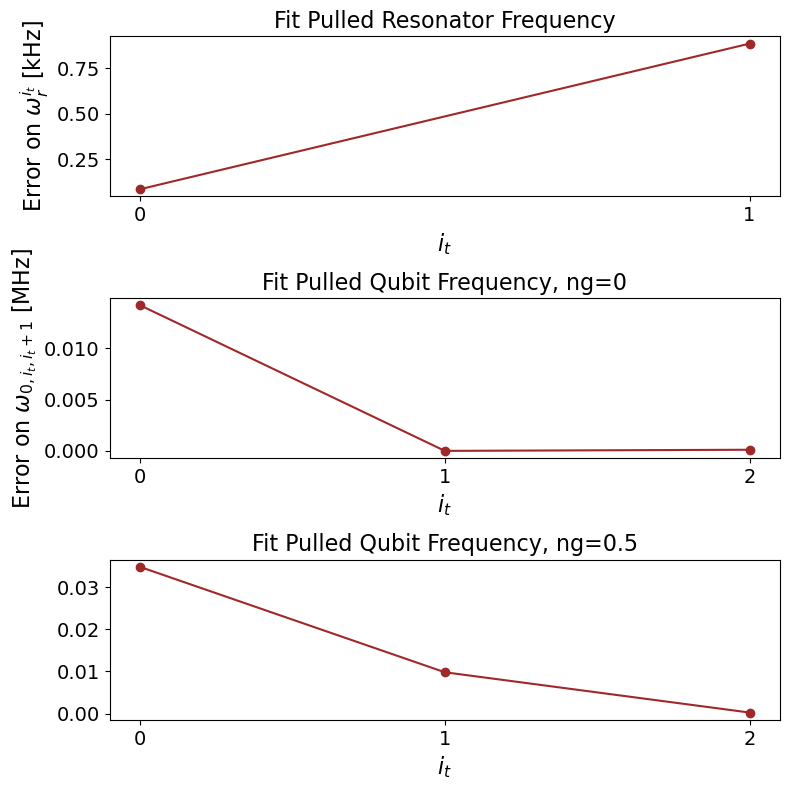

In [126]:
# Minimize loss function
#result = minimize(Loss_function, x0,method='L-BFGS-B', bounds=bounds, options=options,constraints=constraints)
#result = minimize(Loss_function, x0,method='Nelder-Mead', bounds=bounds, options=options,constraints=constraints)
result = minimize(Loss_function, x0,method='SLSQP', bounds=bounds, options=options,constraints=constraints)

# Plot resulting fit vs experiment
Plot_fit_Predictions(result)

paramnames=['EJ', 'EC', 'g', 'fr_b']
print("Loss: ",Loss_function(result.x), ', Iterations: ',result.nit)
for ind,parameter in enumerate(result.x):
    if ind<nb_harmonics:
        paramname=f'EJ{ind+1}'
    else:
        paramname=paramnames[ind+1-nb_harmonics]
    print("Parameter: ",paramname," Bounds: ",bounds[ind]," Optimal value: ",parameter)

In [128]:
# Loss:  5.495476730728773e-05 , Iterations:  48
# Parameter:  EJ1  Bounds:  (0, 87.17)  Optimal value:  8.717862654789487
# Parameter:  EJ2  Bounds:  (-1, 0)  Optimal value:  -0.06694206359451146
# Parameter:  EJ3  Bounds:  (0, 1)  Optimal value:  0.0034684306473925027
# Parameter:  EC  Bounds:  (0.0217, 2.17)  Optimal value:  0.2166222390426093
# Parameter:  g  Bounds:  (0.018600000000000002, 1.8599999999999999)  Optimal value:  0.18647882941197633
# Parameter:  fr_b  Bounds:  (6.34284, 7.75236)  Optimal value:  7.047670130602469

In [129]:
print( -0.06694206359451146/8.717862654789487*100)
print( 0.0034684306473925027/8.717862654789487*100)
print(8.717862654789487/0.2166222390426093)

-0.7678724275121989
0.03978533253775213
40.24454134219661


In [130]:
truncated_dim=21
r_levels=20
EJ=[result.x[0],result.x[1],result.x[2]]
EC=result.x[-3]
g=result.x[-2]
fr=result.x[-1]

print(EJ)

ng=0
coupled_system_00 = CoupledHarmonicTransmonResonator(
    EJ=EJ, 
    EC=EC, 
    ng=ng, 
    truncated_dim=truncated_dim, 
    n_harmonics=nb_harmonics, 
    fr_b=fr, 
    g=g, 
    r_levels=r_levels
)

ng=0.5
coupled_system_05 = CoupledHarmonicTransmonResonator(
    EJ=EJ, 
    EC=EC, 
    ng=ng, 
    truncated_dim=truncated_dim, 
    n_harmonics=nb_harmonics, 
    fr_b=fr, 
    g=g, 
    r_levels=r_levels
)

coupled_system_00.sort_eigenenergies()
coupled_system_05.sort_eigenenergies()
dressed_qubit_00=coupled_system_00.dressed_qubit
dressed_qubit_05=coupled_system_05.dressed_qubit

print(dressed_qubit_00[0],(dressed_qubit_00[0]+dressed_qubit_00[1])/2,(dressed_qubit_00[0]+dressed_qubit_00[1]+dressed_qubit_00[2])/3)
print(f01/GHz,f02_00/GHz/2,f03_00/GHz/3)

print(dressed_qubit_05[0],(dressed_qubit_05[0]+dressed_qubit_05[1])/2,(dressed_qubit_05[0]+dressed_qubit_05[1]+dressed_qubit_05[2])/3)
print(f01/GHz,f02_05/GHz/2,f03_05/GHz/3)


dressed_resonator=coupled_system_00.dressed_resonator
print(dressed_resonator[0])
print(dressed_resonator[0]-dressed_resonator[1])

[8.717862654789487, -0.06694206359451146, 0.0034684306473925027]
3.6037637262419664 5.287426863121745 6.882951278524395
3.60374955 3.4855449999999997 3.3580000000000005
3.6037147521096777 5.288037478683192 6.876958242622012
3.60374955 3.4861849999999994 3.3516
7.054800083202802
0.002500970319123219


# 2 harmonics

In [47]:
nb_freq_fit=3

# Initial Guess

#EJGuess = [json_data['EJ'],-0.1*json_data['EJ'],0.01*json_data['EJ']]
EJGuess = [8.717,-0.07]

nb_harmonics = len(EJGuess)
# ECGuess = json_data['EC']
# gGuess = json_data['g']
# fr_bGuess = json_data['fr_b']
ECGuess = 0.217
gGuess = 0.186
fr_bGuess = 7.0476



#EJGuess = [json_data['EJ'],-0.1*json_data['EJ'],0.01*json_data['EJ']]
EJGuess = [8.736,-0.049]

nb_harmonics = len(EJGuess)
# ECGuess = json_data['EC']
# gGuess = json_data['g']
# fr_bGuess = json_data['fr_b']
ECGuess = 0.217
gGuess = 0.186
fr_bGuess = 7.0476

In [48]:
x0=EJGuess+[ECGuess,gGuess,fr_bGuess]
truncated_dim=21 #Dimension after truncation
r_levels=10 #Resonator states we keep

# Data we fit
fr_meas = json_data['fr_meas']
fq_meas_00 = json_data['fq_meas_00'][:nb_freq_fit]
fq_meas_05 = json_data['fq_meas_05'][:nb_freq_fit]

fq_meas_00_all = json_data['fq_meas_00']
fq_meas_05_all = json_data['fq_meas_05']

# Weights for different transitions
wq_00_weights = np.zeros_like(fq_meas_00)
for i in range(len(wq_00_weights)):
    wq_00_weights[i] = 1/(i+1)
wq_05_weights = np.zeros_like(fq_meas_05)
for i in range(len(wq_05_weights)):
    wq_05_weights[i] = 1/(i+1)
wr_weights = np.zeros_like(fr_meas)
for i in range(len(fr_meas)):
    wr_weights[i] = 1

# Bounds for EJ
EJ_bound = [
    (8.5,9), 
    (-0.06, -0.04),
    (0, 1), (-1, 0),
    (0, 1), (-1, 0),
    (0, 1), (-1, 0),
    (0, 1), (-1, 0)
]

# Bounds for other parameters
bounds = EJ_bound[:nb_harmonics]+[
    (ECGuess*0.1, ECGuess*10),
    (gGuess*0.1, gGuess*10),
    (fr_bGuess*0.9, fr_bGuess*1.1)
]


# Constraints on EJ
def abs_greater_constraint(x, i):
    return abs(x[i]) - abs(x[i+1])
# Create constraints for given n
def create_constraints(n):
    constraints = []
    for i in range(n - 1):
        constraints.append(NonlinearConstraint(lambda x, i=i: abs_greater_constraint(x, i), 0, np.inf))
    return constraints
# Create constraints
constraints = create_constraints(len(EJGuess))

# Options for the optimizer
options = {
    'ftol': 1e-12,  # Function tolerance
    'maxfun': 100000,  # Maximum number of function evaluations
    #'maxiter': 100000,
    #'eps': 1e-9
}

/var/folders/6v/y8v8x2ds6b55nwr0_7jg1q1r0000gq/T/ipykernel_70502/2124237325.py:4: OptimizeWarning: Unknown solver options: maxfun
  result = minimize(Loss_function, x0,method='SLSQP', bounds=bounds, options=options,constraints=constraints)
/Users/dumm3209/opt/anaconda3/envs/accelerate/lib/python3.11/site-packages/scipy/optimize/_slsqp_py.py:437: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)


[ 3.60374954  6.97119064 10.07288726]
[ 3.60370465  6.97237061 10.05479988]
[1.08944622e-05 1.00644828e-01 1.11273651e+00]  MHz
[0.04489545 0.00061428 0.00012467]  MHz
[0.00711651 0.01426063]  kHz
Loss:  0.0004665110009409723 , Iterations:  61
Parameter:  EJ1  Bounds:  (8.5, 9)  Optimal value:  8.736513735040992
Parameter:  EJ2  Bounds:  (-0.06, -0.04)  Optimal value:  -0.0492991625502278
Parameter:  EC  Bounds:  (0.0217, 2.17)  Optimal value:  0.21503143312241624
Parameter:  g  Bounds:  (0.018600000000000002, 1.8599999999999999)  Optimal value:  0.18578159291712237
Parameter:  fr_b  Bounds:  (6.34284, 7.75236)  Optimal value:  7.047670972445865


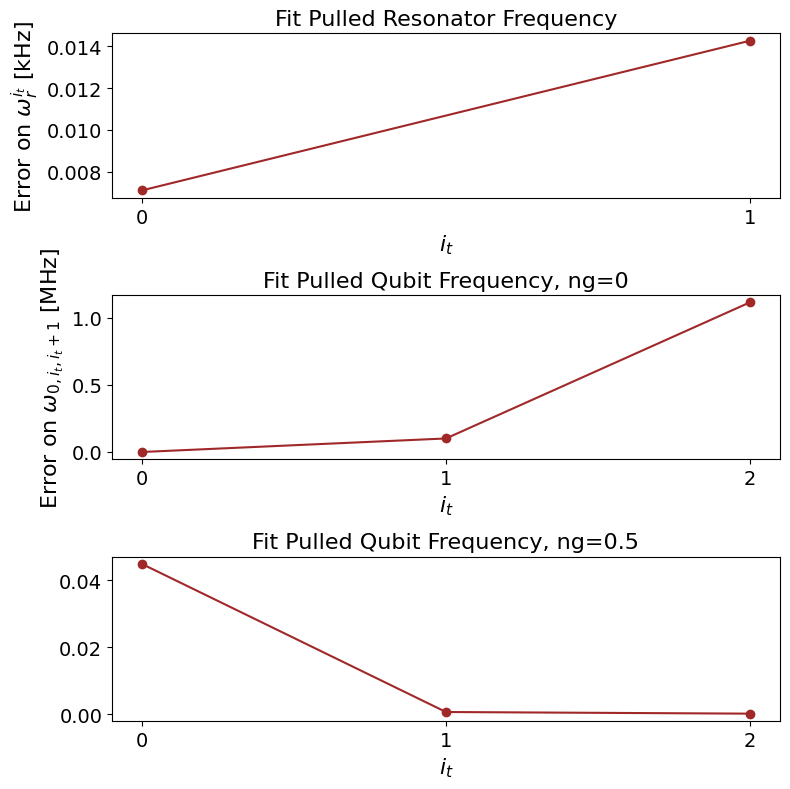

In [49]:
# Minimize loss function
#result = minimize(Loss_function, x0,method='L-BFGS-B', bounds=bounds, options=options,constraints=constraints)
#result = minimize(Loss_function, x0,method='Nelder-Mead', bounds=bounds, options=options,constraints=constraints)
result = minimize(Loss_function, x0,method='SLSQP', bounds=bounds, options=options,constraints=constraints)

# Plot resulting fit vs experiment
Plot_fit_Predictions(result)

paramnames=['EJ', 'EC', 'g', 'fr_b']
print("Loss: ",Loss_function(result.x), ', Iterations: ',result.nit)
for ind,parameter in enumerate(result.x):
    if ind<nb_harmonics:
        paramname=f'EJ{ind+1}'
    else:
        paramname=paramnames[ind+1-nb_harmonics]
    print("Parameter: ",paramname," Bounds: ",bounds[ind]," Optimal value: ",parameter)

/var/folders/6v/y8v8x2ds6b55nwr0_7jg1q1r0000gq/T/ipykernel_70502/2124237325.py:4: OptimizeWarning: Unknown solver options: maxfun
  result = minimize(Loss_function, x0,method='SLSQP', bounds=bounds, options=options,constraints=constraints)


[ 3.60374957  6.97119005 10.07288568]
[ 3.60370469  6.97236985 10.05480041]
[1.9858823e-05 1.0004638e-01 1.1143172e+00]  MHz
[0.04485773 0.00014501 0.00040709]  MHz
[4.52970994e-07 1.55553735e-01]  kHz
Loss:  0.0004667036045572873 , Iterations:  78
Parameter:  EJ1  Bounds:  (0, 87.2)  Optimal value:  8.736564533862802
Parameter:  EJ2  Bounds:  (-0.06, -0.04)  Optimal value:  -0.049283744992917246
Parameter:  EC  Bounds:  (0.0217, 2.17)  Optimal value:  0.21502889125244906
Parameter:  g  Bounds:  (0.018600000000000002, 1.8599999999999999)  Optimal value:  0.1857857707901933
Parameter:  fr_b  Bounds:  (6.34284, 7.75236)  Optimal value:  7.047670570620455


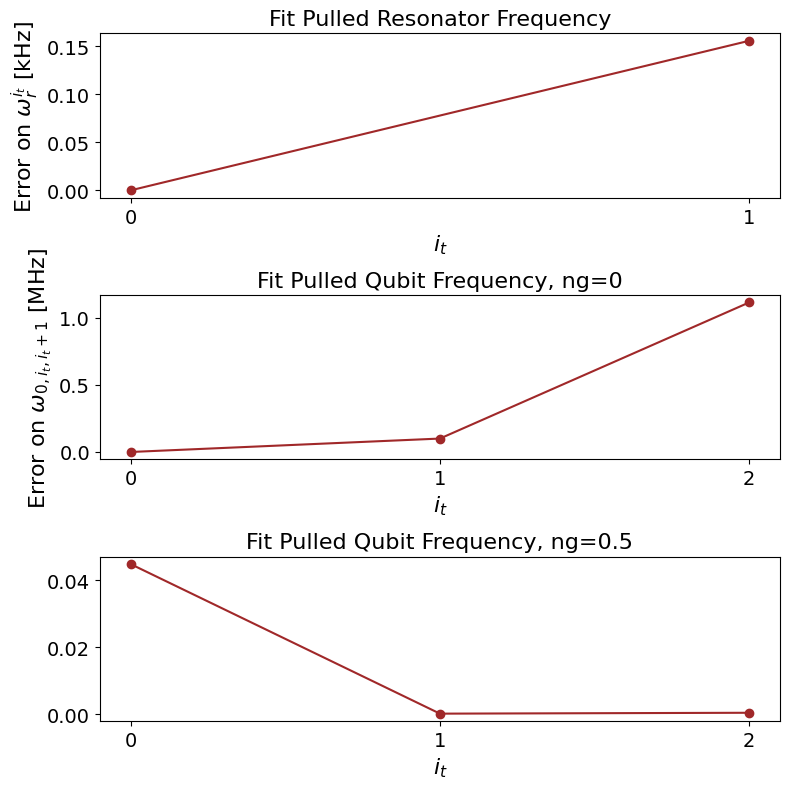

In [44]:
# Minimize loss function
#result = minimize(Loss_function, x0,method='L-BFGS-B', bounds=bounds, options=options,constraints=constraints)
#result = minimize(Loss_function, x0,method='Nelder-Mead', bounds=bounds, options=options,constraints=constraints)
result = minimize(Loss_function, x0,method='SLSQP', bounds=bounds, options=options,constraints=constraints)

# Plot resulting fit vs experiment
Plot_fit_Predictions(result)

paramnames=['EJ', 'EC', 'g', 'fr_b']
print("Loss: ",Loss_function(result.x), ', Iterations: ',result.nit)
for ind,parameter in enumerate(result.x):
    if ind<nb_harmonics:
        paramname=f'EJ{ind+1}'
    else:
        paramname=paramnames[ind+1-nb_harmonics]
    print("Parameter: ",paramname," Bounds: ",bounds[ind]," Optimal value: ",parameter)

/var/folders/6v/y8v8x2ds6b55nwr0_7jg1q1r0000gq/T/ipykernel_70502/2124237325.py:4: OptimizeWarning: Unknown solver options: maxfun
  result = minimize(Loss_function, x0,method='SLSQP', bounds=bounds, options=options,constraints=constraints)
/Users/dumm3209/opt/anaconda3/envs/accelerate/lib/python3.11/site-packages/scipy/optimize/_slsqp_py.py:437: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)


[ 3.6037495   6.97163083 10.07400584]
[ 3.60369929  6.97293292 10.05432567]
[4.99663901e-05 5.40827078e-01 5.84131728e-03]  MHz
[0.05025861 0.56292374 0.47433218]  MHz
[1.67505713 6.10558716]  kHz
Loss:  0.0007700224620770986 , Iterations:  100
Parameter:  EJ1  Bounds:  (0, 87.17)  Optimal value:  8.699498531494182
Parameter:  EJ2  Bounds:  (-0.07, -0.06)  Optimal value:  -0.06
Parameter:  EC  Bounds:  (0.0217, 2.17)  Optimal value:  0.21692794090202425
Parameter:  g  Bounds:  (0.018600000000000002, 1.8599999999999999)  Optimal value:  0.18642225912573476
Parameter:  fr_b  Bounds:  (6.34284, 7.75236)  Optimal value:  7.047682818754753


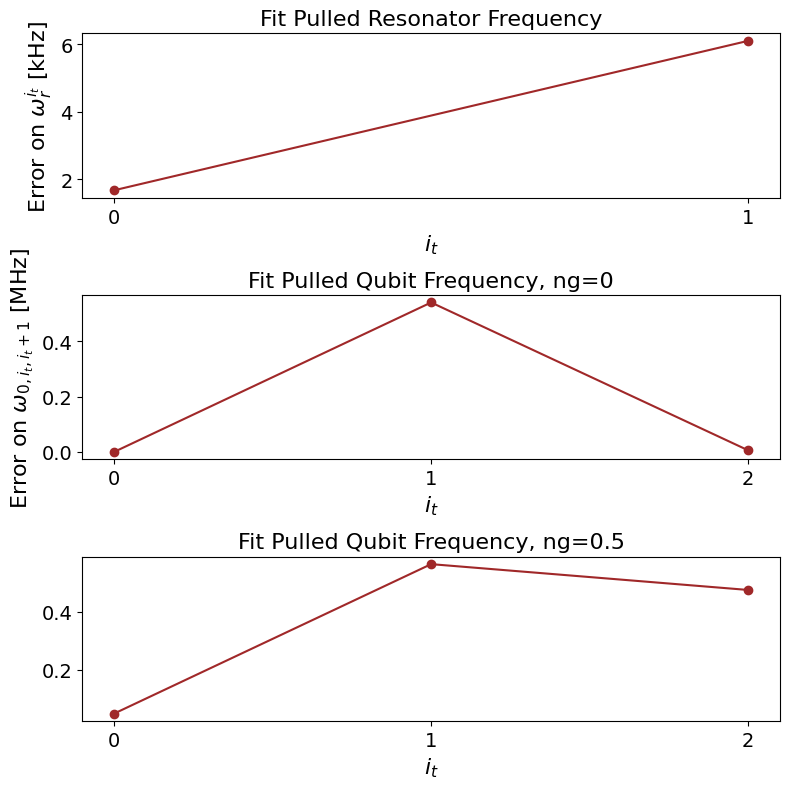

In [37]:
# Minimize loss function
#result = minimize(Loss_function, x0,method='L-BFGS-B', bounds=bounds, options=options,constraints=constraints)
#result = minimize(Loss_function, x0,method='Nelder-Mead', bounds=bounds, options=options,constraints=constraints)
result = minimize(Loss_function, x0,method='SLSQP', bounds=bounds, options=options,constraints=constraints)

# Plot resulting fit vs experiment
Plot_fit_Predictions(result)

paramnames=['EJ', 'EC', 'g', 'fr_b']
print("Loss: ",Loss_function(result.x), ', Iterations: ',result.nit)
for ind,parameter in enumerate(result.x):
    if ind<nb_harmonics:
        paramname=f'EJ{ind+1}'
    else:
        paramname=paramnames[ind+1-nb_harmonics]
    print("Parameter: ",paramname," Bounds: ",bounds[ind]," Optimal value: ",parameter)

In [38]:
result.x

array([ 8.69949853, -0.06      ,  0.21692794,  0.18642226,  7.04768282])

In [25]:
result.x

array([ 8.71335773, -0.05664736,  0.21627025,  0.18643454,  7.04766191])

In [61]:
nb_harmonics=2

result_x=np.array([ 8.71335773, -0.05664736,  0.21627025,  0.18643454,  7.04766191])
result_test=np.array([8.717862654789487,-0.06694206359451146,0.2166222390426093,0.18647882941197633,7.047670130602469])

In [62]:
paramnames=['EJ', 'EC', 'g', 'fr_b']
print("Loss: ",Loss_function(result_x))
print("Loss: ",Loss_function(result_test))

Loss:  0.0005581581108993205
Loss:  0.008018987618430451


In [63]:
nb_harmonics=1
result_noharm=np.array([ 8.717862654789487,0.2166222390426093,0.18647882941197633,7.047670130602469])
print("Loss: ",Loss_function(result_noharm))


nb_harmonics=2
result_2harm=np.array([ 8.717862654789487,-0.06694206359451146,0.2166222390426093,0.18647882941197633,7.047670130602469])
print("Loss: ",Loss_function(result_2harm))


nb_harmonics=3
result_3harm=np.array([ 8.717862654789487,-0.06694206359451146,0.0034684306473925027,0.2166222390426093,0.18647882941197633,7.047670130602469])
print("Loss: ",Loss_function(result_3harm))

Loss:  0.18468514515772597
Loss:  0.008018987618430451
Loss:  5.49547672673197e-05


In [24]:
truncated_dim=21
r_levels=20
EJ=[result.x[0],result.x[1],result.x[2]]
EC=result.x[-3]
g=result.x[-2]
fr=result.x[-1]

print(EJ)

ng=0
coupled_system_00 = CoupledHarmonicTransmonResonator(
    EJ=EJ, 
    EC=EC, 
    ng=ng, 
    truncated_dim=truncated_dim, 
    n_harmonics=nb_harmonics, 
    fr_b=fr, 
    g=g, 
    r_levels=r_levels
)

ng=0.5
coupled_system_05 = CoupledHarmonicTransmonResonator(
    EJ=EJ, 
    EC=EC, 
    ng=ng, 
    truncated_dim=truncated_dim, 
    n_harmonics=nb_harmonics, 
    fr_b=fr, 
    g=g, 
    r_levels=r_levels
)

coupled_system_00.sort_eigenenergies()
coupled_system_05.sort_eigenenergies()
dressed_qubit_00=coupled_system_00.dressed_qubit
dressed_qubit_05=coupled_system_05.dressed_qubit

print(dressed_qubit_00[0],(dressed_qubit_00[0]+dressed_qubit_00[1])/2,(dressed_qubit_00[0]+dressed_qubit_00[1]+dressed_qubit_00[2])/3)
print(f01/GHz,f02_00/GHz/2,f03_00/GHz/3)

print(dressed_qubit_05[0],(dressed_qubit_05[0]+dressed_qubit_05[1])/2,(dressed_qubit_05[0]+dressed_qubit_05[1]+dressed_qubit_05[2])/3)
print(f01/GHz,f02_05/GHz/2,f03_05/GHz/3)


dressed_resonator=coupled_system_00.dressed_resonator
print(dressed_resonator[0])
print(dressed_resonator[0]-dressed_resonator[1])

[np.float64(8.71335772762306), np.float64(-0.056647357736867146), np.float64(0.21627025267625855)]
3.7634574975918875 5.438699741152538 7.00411853798219
3.60374955 3.4855449999999997 3.3580000000000005
3.763406564040726 5.439364108669645 6.997946674731414
3.60374955 3.4861849999999994 3.3516
7.055659373319924
0.004572843362323553


# No harmonics, 3 freq

In [163]:
nb_freq_fit=3

# Initial Guess

#EJGuess = [json_data['EJ'],-0.1*json_data['EJ'],0.01*json_data['EJ']]
EJGuess = [8.96,0,0]

nb_harmonics = len(EJGuess)
# ECGuess = json_data['EC']
# gGuess = json_data['g']
# fr_bGuess = json_data['fr_b']
ECGuess = 0.205
gGuess = 0.182
fr_bGuess = 7.0476

In [164]:
x0=EJGuess+[ECGuess,gGuess,fr_bGuess]
truncated_dim=21 #Dimension after truncation
r_levels=10 #Resonator states we keep

# Data we fit
fr_meas = json_data['fr_meas']
fq_meas_00 = json_data['fq_meas_00'][:nb_freq_fit]
fq_meas_05 = json_data['fq_meas_05'][:nb_freq_fit]

fq_meas_00_all = json_data['fq_meas_00']
fq_meas_05_all = json_data['fq_meas_05']

# Weights for different transitions
wq_00_weights = np.zeros_like(fq_meas_00)
for i in range(len(wq_00_weights)):
    wq_00_weights[i] = 1/(i+1)
wq_05_weights = np.zeros_like(fq_meas_05)
for i in range(len(wq_05_weights)):
    wq_05_weights[i] = 1/(i+1)
wr_weights = np.zeros_like(fr_meas)
for i in range(len(fr_meas)):
    wr_weights[i] = 1

# Bounds for EJ
EJ_bound = [
    (0, EJGuess[0]*10), 
    (0, 0),
    (0, 0), (0, 0),
    (0, 0), (0, 0),
    (0, 0), (0, 0),
    (0, 0), (0, 0)
]

# Bounds for other parameters
bounds = EJ_bound[:nb_harmonics]+[
    (ECGuess*0.1, ECGuess*10),
    (gGuess*0.1, gGuess*10),
    (fr_bGuess*0.9, fr_bGuess*1.1)
]


# Constraints on EJ
def abs_greater_constraint(x, i):
    return abs(x[i]) - abs(x[i+1])
# Create constraints for given n
def create_constraints(n):
    constraints = []
    for i in range(n - 1):
        constraints.append(NonlinearConstraint(lambda x, i=i: abs_greater_constraint(x, i), 0, np.inf))
    return constraints
# Create constraints
constraints = create_constraints(len(EJGuess))

# Options for the optimizer
options = {
    'ftol': 1e-12,  # Function tolerance
    'maxfun': 100000,  # Maximum number of function evaluations
    #'maxiter': 100000,
    #'eps': 1e-9
}

/var/folders/6v/y8v8x2ds6b55nwr0_7jg1q1r0000gq/T/ipykernel_25229/452198918.py:6: OptimizeWarning: Unknown solver options: maxfun
  result = minimize(Loss_function, x0,method='SLSQP', bounds=bounds, options=options,constraints=constraints)


[ 3.60377401  6.97109005 10.07381412]
[ 3.60374946  6.97178128 10.06242937]
[2.44632287e-02 5.21276027e-05 1.85881914e-01]
[9.16809721e-05 5.88722346e-01 7.62937414e+00]
Loss:  0.002924329476414448 , Iterations:  27
Parameter:  EJ1  Bounds:  (0, 89.60000000000001)  Optimal value:  8.94760929764842
Parameter:  EJ2  Bounds:  (0, 0)  Optimal value:  0.0
Parameter:  EJ3  Bounds:  (0, 0)  Optimal value:  0.0
Parameter:  EC  Bounds:  (0.0205, 2.05)  Optimal value:  0.2055693774577475
Parameter:  g  Bounds:  (0.0182, 1.8199999999999998)  Optimal value:  0.18184849843880857
Parameter:  fr_b  Bounds:  (6.34284, 7.75236)  Optimal value:  7.047655005798805


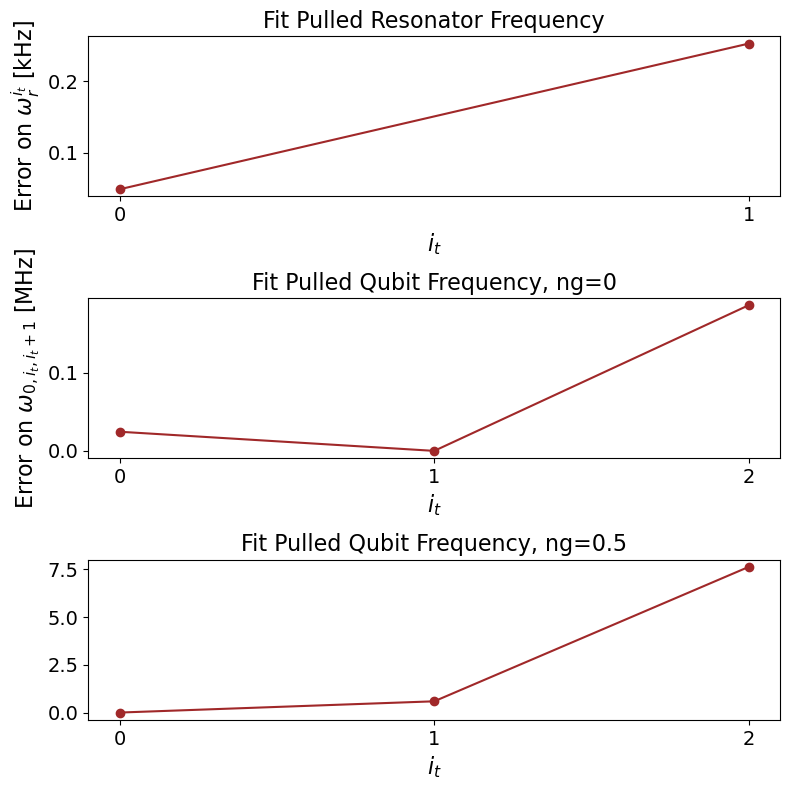

In [165]:
# Minimize loss function
#result = minimize(Loss_function, x0,method='L-BFGS-B', bounds=bounds, options=options,constraints=constraints)
#result = minimize(Loss_function, x0,method='Nelder-Mead', bounds=bounds, options=options,constraints=constraints)
result = minimize(Loss_function, x0,method='SLSQP', bounds=bounds, options=options,constraints=constraints)

# Plot resulting fit vs experiment
Plot_fit_Predictions(result)

paramnames=['EJ', 'EC', 'g', 'fr_b']
print("Loss: ",Loss_function(result.x), ', Iterations: ',result.nit)
for ind,parameter in enumerate(result.x):
    if ind<nb_harmonics:
        paramname=f'EJ{ind+1}'
    else:
        paramname=paramnames[ind+1-nb_harmonics]
    print("Parameter: ",paramname," Bounds: ",bounds[ind]," Optimal value: ",parameter)

In [166]:
minimizer_kwargs = {"method": "SLSQP",
                   "bounds": bounds,
                   "options":options
                   }

result = basinhopping(Loss_function, x0,niter=100,minimizer_kwargs=minimizer_kwargs)

[ 3.60377395  6.97109033 10.07381513]
[ 3.6037494   6.97178155 10.06243051]
[0.02440189 0.00033415 0.18486769]
[1.52703221e-04 5.88448683e-01 7.63051358e+00]
Loss:  0.0029240796594871554 , Iterations:  100
Parameter:  EJ1  Bounds:  (0, 89.60000000000001)  Optimal value:  8.947616902851571
Parameter:  EJ2  Bounds:  (0, 0)  Optimal value:  0.0
Parameter:  EJ3  Bounds:  (0, 0)  Optimal value:  0.0
Parameter:  EC  Bounds:  (0.0205, 2.05)  Optimal value:  0.20556937872018627
Parameter:  g  Bounds:  (0.0182, 1.8199999999999998)  Optimal value:  0.18185975578389965
Parameter:  fr_b  Bounds:  (6.34284, 7.75236)  Optimal value:  7.047654163667993


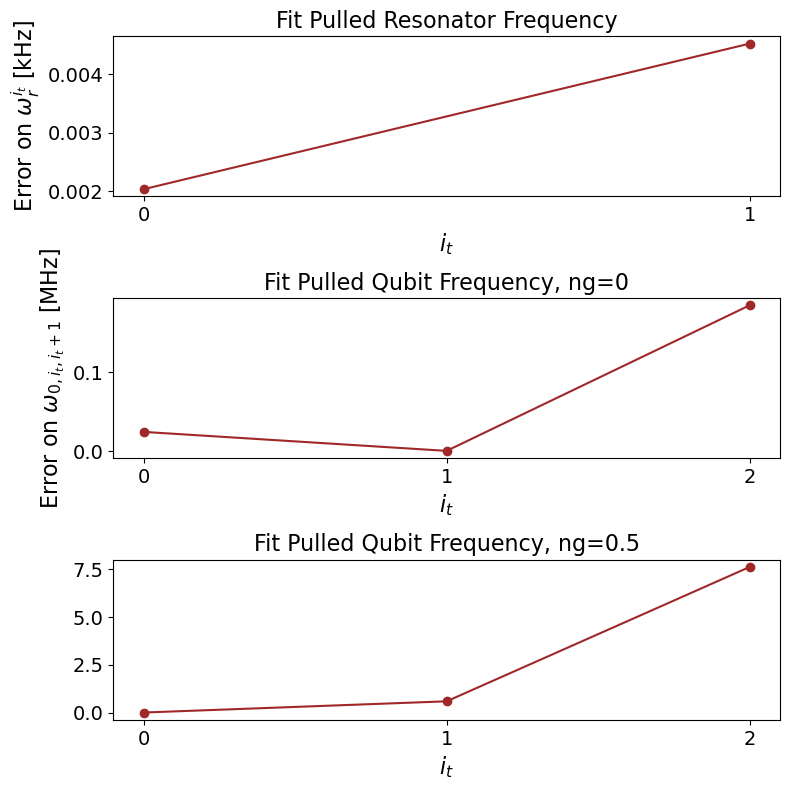

In [167]:
# Plot resulting fit vs experiment
Plot_fit_Predictions(result)

paramnames=['EJ', 'EC', 'g', 'fr_b']
print("Loss: ",Loss_function(result.x), ', Iterations: ',result.nit)
for ind,parameter in enumerate(result.x):
    if ind<nb_harmonics:
        paramname=f'EJ{ind+1}'
    else:
        paramname=paramnames[ind+1-nb_harmonics]
    print("Parameter: ",paramname," Bounds: ",bounds[ind]," Optimal value: ",parameter)

# No harmonics, 2 freq

In [160]:
nb_freq_fit=2

# Initial Guess

#EJGuess = [json_data['EJ'],-0.1*json_data['EJ'],0.01*json_data['EJ']]
EJGuess = [8.96,0,0]

nb_harmonics = len(EJGuess)
# ECGuess = json_data['EC']
# gGuess = json_data['g']
# fr_bGuess = json_data['fr_b']
ECGuess = 0.205
gGuess = 0.182
fr_bGuess = 7.0476

In [161]:
x0=EJGuess+[ECGuess,gGuess,fr_bGuess]
truncated_dim=21 #Dimension after truncation
r_levels=10 #Resonator states we keep

# Data we fit
fr_meas = json_data['fr_meas']
fq_meas_00 = json_data['fq_meas_00'][:nb_freq_fit]
fq_meas_05 = json_data['fq_meas_05'][:nb_freq_fit]

fq_meas_00_all = json_data['fq_meas_00']
fq_meas_05_all = json_data['fq_meas_05']

# Weights for different transitions
wq_00_weights = np.zeros_like(fq_meas_00)
for i in range(len(wq_00_weights)):
    wq_00_weights[i] = 1/(i+1)
wq_05_weights = np.zeros_like(fq_meas_05)
for i in range(len(wq_05_weights)):
    wq_05_weights[i] = 1/(i+1)
wr_weights = np.zeros_like(fr_meas)
for i in range(len(fr_meas)):
    wr_weights[i] = 1

# Bounds for EJ
EJ_bound = [
    (0, EJGuess[0]*10), 
    (0, 0),
    (0, 0), (0, 0),
    (0, 0), (0, 0),
    (0, 0), (0, 0),
    (0, 0), (0, 0)
]

# Bounds for other parameters
bounds = EJ_bound[:nb_harmonics]+[
    (ECGuess*0.1, ECGuess*10),
    (gGuess*0.1, gGuess*10),
    (fr_bGuess*0.9, fr_bGuess*1.1)
]


# Constraints on EJ
def abs_greater_constraint(x, i):
    return abs(x[i]) - abs(x[i+1])
# Create constraints for given n
def create_constraints(n):
    constraints = []
    for i in range(n - 1):
        constraints.append(NonlinearConstraint(lambda x, i=i: abs_greater_constraint(x, i), 0, np.inf))
    return constraints
# Create constraints
constraints = create_constraints(len(EJGuess))

# Options for the optimizer
options = {
    'ftol': 1e-12,  # Function tolerance
    'maxfun': 100000,  # Maximum number of function evaluations
    #'maxiter': 100000,
    #'eps': 1e-9
}

/var/folders/6v/y8v8x2ds6b55nwr0_7jg1q1r0000gq/T/ipykernel_25229/81283725.py:6: OptimizeWarning: Unknown solver options: maxfun
  result = minimize(Loss_function, x0,method='SLSQP', bounds=bounds, options=options,constraints=constraints)


[ 3.60377367  6.97132619 10.07453548]
[ 3.60374944  6.97200903 10.06327445]
[0.02412163 0.23618517 0.53547868]
[1.10167194e-04 3.60965601e-01 8.47444867e+00]
Loss:  0.0003231728656594157 , Iterations:  50
Parameter:  EJ1  Bounds:  (0, 89.60000000000001)  Optimal value:  8.954116557988709
Parameter:  EJ2  Bounds:  (0, 0)  Optimal value:  0.0
Parameter:  EJ3  Bounds:  (0, 0)  Optimal value:  0.0
Parameter:  EC  Bounds:  (0.0205, 2.05)  Optimal value:  0.20540105716947735
Parameter:  g  Bounds:  (0.0182, 1.8199999999999998)  Optimal value:  0.18186634059887916
Parameter:  fr_b  Bounds:  (6.34284, 7.75236)  Optimal value:  7.047647315351689


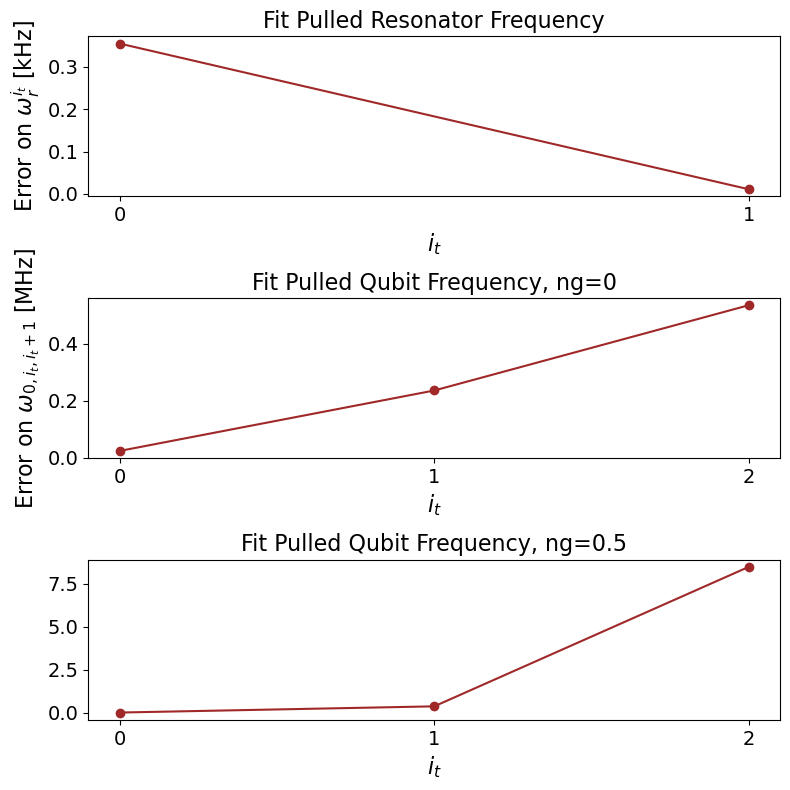

In [162]:
# Minimize loss function
#result = minimize(Loss_function, x0,method='L-BFGS-B', bounds=bounds, options=options,constraints=constraints)
#result = minimize(Loss_function, x0,method='Nelder-Mead', bounds=bounds, options=options,constraints=constraints)
result = minimize(Loss_function, x0,method='SLSQP', bounds=bounds, options=options,constraints=constraints)

# Plot resulting fit vs experiment
Plot_fit_Predictions(result)

paramnames=['EJ', 'EC', 'g', 'fr_b']
print("Loss: ",Loss_function(result.x), ', Iterations: ',result.nit)
for ind,parameter in enumerate(result.x):
    if ind<nb_harmonics:
        paramname=f'EJ{ind+1}'
    else:
        paramname=paramnames[ind+1-nb_harmonics]
    print("Parameter: ",paramname," Bounds: ",bounds[ind]," Optimal value: ",parameter)

In [154]:
minimizer_kwargs = {"method": "SLSQP",
                   "bounds": bounds,
                   "options":options
                   }

result = basinhopping(Loss_function, x0,niter=100,minimizer_kwargs=minimizer_kwargs)

/Users/dumm3209/opt/anaconda3/envs/accelerate/lib/python3.11/site-packages/scipy/optimize/_basinhopping.py:292: OptimizeWarning: Unknown solver options: maxfun
  return self.minimizer(self.func, x0, **self.kwargs)


[ 3.60377394  6.97109246 10.07382166]
[ 3.60374938  6.9717836  10.06243817]
[0.02438537 0.00245846 0.17833936]
[1.66272275e-04 5.86400898e-01 7.63817140e+00]
Loss:  0.00031899390565870434 , Iterations:  100
Parameter:  EJ1  Bounds:  (0, 89.60000000000001)  Optimal value:  8.947675993601024
Parameter:  EJ2  Bounds:  (0, 0)  Optimal value:  0.0
Parameter:  EJ3  Bounds:  (0, 0)  Optimal value:  0.0
Parameter:  EC  Bounds:  (0.0205, 2.05)  Optimal value:  0.20556785161180988
Parameter:  g  Bounds:  (0.0182, 1.8199999999999998)  Optimal value:  0.18186015074310616
Parameter:  fr_b  Bounds:  (6.34284, 7.75236)  Optimal value:  7.04765407613599


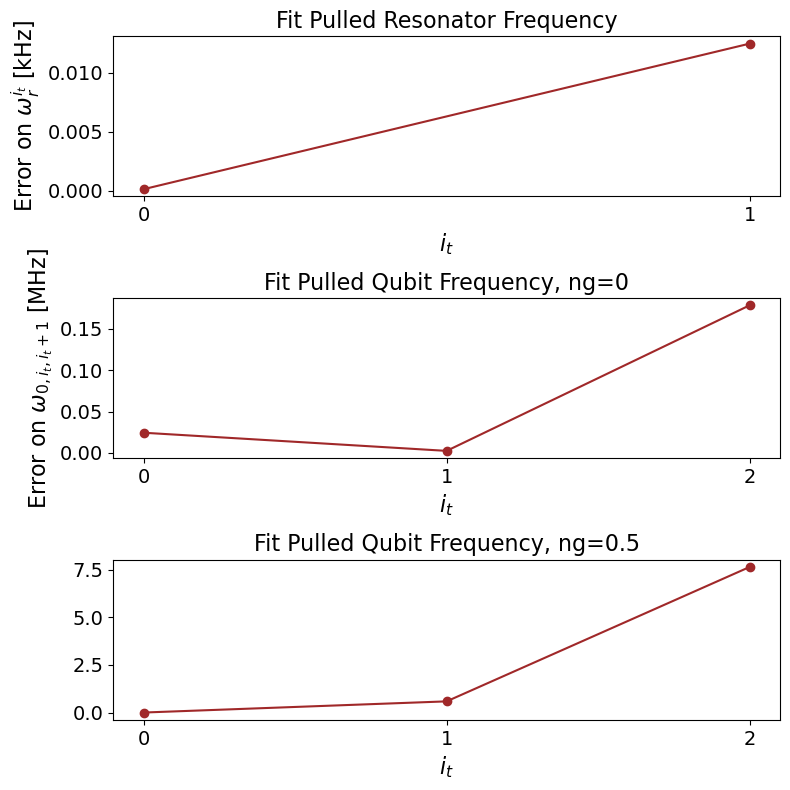

In [156]:
# Plot resulting fit vs experiment
Plot_fit_Predictions(result)

paramnames=['EJ', 'EC', 'g', 'fr_b']
print("Loss: ",Loss_function(result.x), ', Iterations: ',result.nit)
for ind,parameter in enumerate(result.x):
    if ind<nb_harmonics:
        paramname=f'EJ{ind+1}'
    else:
        paramname=paramnames[ind+1-nb_harmonics]
    print("Parameter: ",paramname," Bounds: ",bounds[ind]," Optimal value: ",parameter)